District: Golaghat
Year: 2012
Agricultural Land: 0.0042
Forest: 0.0001
Waterbodies: 0.0114
Grasslands: 0.0685
Urbanisation: 0.0040

Year: 2013
Agricultural Land: 0.0034
Forest: 0.0001
Waterbodies: 0.0115
Grasslands: 0.0693
Urbanisation: 0.0032

Year: 2015
Agricultural Land: 0.0088
Forest: 0.0000
Waterbodies: 0.0077
Grasslands: 0.0470
Urbanisation: 0.0084

Year: 2016
Agricultural Land: 0.0082
Forest: 0.0000
Waterbodies: 0.0082
Grasslands: 0.0491
Urbanisation: 0.0079

Year: 2018
Agricultural Land: 0.0014
Forest: 0.0000
Waterbodies: 0.0133
Grasslands: 0.0707
Urbanisation: 0.0013

Year: 2019
Agricultural Land: 0.0013
Forest: 0.0008
Waterbodies: 0.0000
Grasslands: 0.0344
Urbanisation: 0.0012

Year: 2021
Agricultural Land: 0.0047
Forest: 0.0004
Waterbodies: 0.0076
Grasslands: 0.0479
Urbanisation: 0.0046

Year: 2022
Agricultural Land: 0.0020
Forest: 0.0012
Waterbodies: 0.0124
Grasslands: 0.0635
Urbanisation: 0.0019

District: Nagaon
Year: 2012
Agricultural Land: 0.0015
Forest: 0.0001
Waterbod

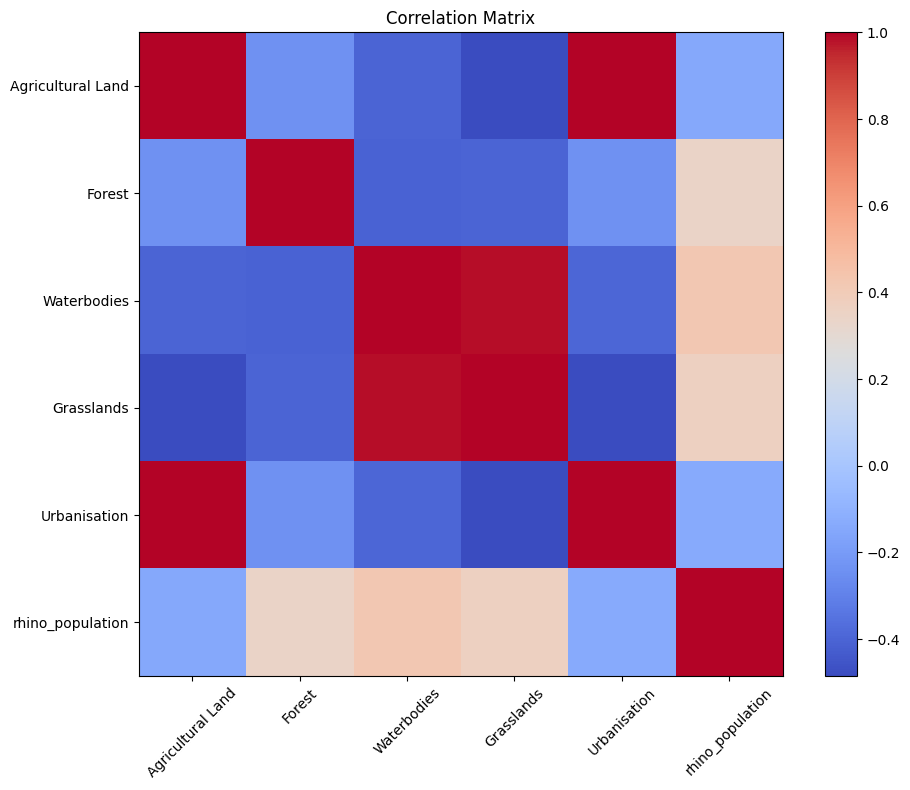

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

lulc_paths = {
    'Golaghat': {
        '2012': '/kaggle/input/land-use-cover-g/2012.jpg',
        '2013': '/kaggle/input/land-use-cover-g/2013.jpg',
        '2015': '/kaggle/input/land-use-cover-g/2015.jpg',
        '2016': '/kaggle/input/land-use-cover-g/2016.jpg',
        '2018': '/kaggle/input/land-use-cover-g/2018.jpg',
        '2019': '/kaggle/input/land-use-cover-g/2019.png',
        '2021': '/kaggle/input/land-use-cover-g/2021.jpg',
        '2022': '/kaggle/input/land-use-cover-g/2022.jpg'
    },
    'Nagaon': {
        '2012': '/kaggle/input/land-use-cover-nagaon/2012.jpg',
        '2013': '/kaggle/input/land-use-cover-nagaon/2013.jpg',
        '2015': '/kaggle/input/land-use-cover-nagaon/2015.jpg',
        '2016': '/kaggle/input/land-use-cover-nagaon/2016.jpg',
        '2018': '/kaggle/input/land-use-cover-nagaon/2018.jpg',
        '2019': '/kaggle/input/land-use-cover-nagaon/2019.jpg',
        '2021': '/kaggle/input/land-use-cover-nagaon/2022.png',
        '2022': '/kaggle/input/land-use-cover-nagaon/2022.png'
    }
}

rhino_population = {
    '2012': 2290,
    '2013': 2329,
    '2015': 2401,
    '2016': 2401,
    '2018': 2413,
    '2019': 2413,
    '2021': 2613,
    '2022': 2613
}

def read_and_preprocess_image(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    # Read image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not loaded correctly: {path}")
    # Normalize image
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    return img

def calculate_land_cover_percentages(lulc_paths):
    land_cover_data = {}
    for district, year_paths in lulc_paths.items():
        land_cover_data[district] = {}
        for year, path in year_paths.items():
            try:
                img = read_and_preprocess_image(path)
                total_pixels = img.shape[0] * img.shape[1]
                agricultural_pixels = np.count_nonzero(img == 128) / total_pixels
                forest_pixels = np.count_nonzero(img == 0) / total_pixels
                waterbody_pixels = np.count_nonzero(img == 64) / total_pixels  # Assuming waterbodies are represented by value 64
                grasslands_pixels = np.count_nonzero((img == 53) | (img == 69) | (img == 56) | (img == 81) | (img == 91) | (img == 66)) / total_pixels
                urban_pixels = np.count_nonzero(img == 129) / total_pixels

                land_cover_data[district][year] = {
                    'Total Pixels': total_pixels,
                    'Agricultural Land': agricultural_pixels,
                    'Forest': forest_pixels,
                    'Waterbodies': waterbody_pixels,
                    'Grasslands': grasslands_pixels,
                    'Urbanisation': urban_pixels
                }
            except Exception as e:
                print(f"Error processing {year} for {district}: {e}")
    return land_cover_data

try:
    # Calculate land cover percentages
    land_cover_percentages = calculate_land_cover_percentages(lulc_paths)

    data = []
    for district, years in land_cover_percentages.items():
        for year, cover_data in years.items():
            year = int(year)
            row = {
                'District': district,
                'Year': year,
                'Agricultural Land': cover_data['Agricultural Land'],
                'Forest': cover_data['Forest'],
                'Waterbodies': cover_data['Waterbodies'],
                'Grasslands': cover_data['Grasslands'],
                'Urbanisation': cover_data['Urbanisation'],
                'rhino_population': rhino_population.get(str(year), np.nan)  # Convert year to string for lookup
            }
            data.append(row)

    df = pd.DataFrame(data)
    df = df.dropna()

    df['rhino_population'] = pd.to_numeric(df['rhino_population'], errors='coerce')

    # Print pixel data for each category
    for district, years in land_cover_percentages.items():
        print(f"District: {district}")
        for year, cover_data in years.items():
            print(f"Year: {year}")
            print(f"Agricultural Land: {cover_data['Agricultural Land']:.4f}")
            print(f"Forest: {cover_data['Forest']:.4f}")
            print(f"Waterbodies: {cover_data['Waterbodies']:.4f}")
            print(f"Grasslands: {cover_data['Grasslands']:.4f}")
            print(f"Urbanisation: {cover_data['Urbanisation']:.4f}")
            print()

    correlation_matrix = df[['Agricultural Land', 'Forest', 'Waterbodies', 'Grasslands', 'Urbanisation', 'rhino_population']].corr()
    print("Correlation Matrix:")
    print(correlation_matrix)

    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.title('Correlation Matrix')
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
    plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error during analysis: {e}")


2024-07-23 12:46:03.439255: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 12:46:03.439426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 12:46:03.582552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 Predictions for 2023:
  Predicted Population:  2597

  Golaghat Land Cover: {'Agricultural Land': 0.0482574, 'Forest': 0.23606929, 'Urbanisation': 0.0032306642, 'Water Bodies': 0.6784928, 'Grasslands': 0.033949833}

  Nagaon Land Cover: {'Agricultural Land': 0.14644773, 'Forest': 0.35770446, 'Urbanisation': 0.16524155, 'Water Bodies': 0.31532818, 'Grasslands': 0.015278125}

  Suggestions for Golaghat in 2023:
  - Increase grassland areas to provide more grazing habitats for rhinos.

  Suggestions for Nagaon in 2023:
  - Increase grassland areas to provide more grazing habitats for rhinos.
  - Control urban development to minimize habitat fragmentation and human-wildlife conflict.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 Predictions for 2024: 

  Predicted Population:  2431

  Golaghat Land Cover: {

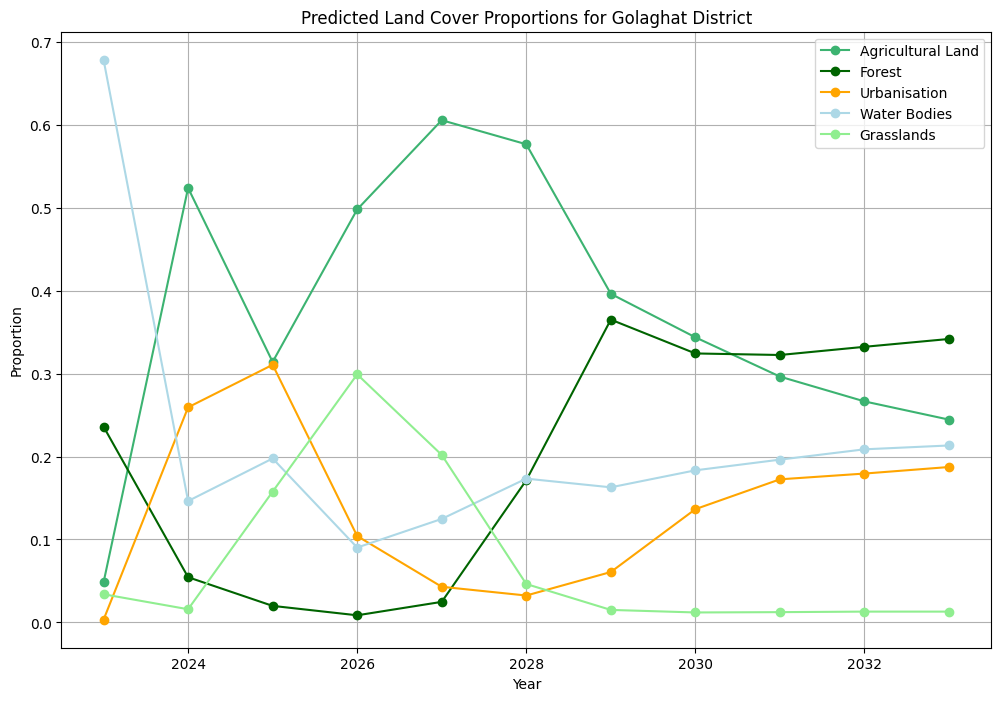

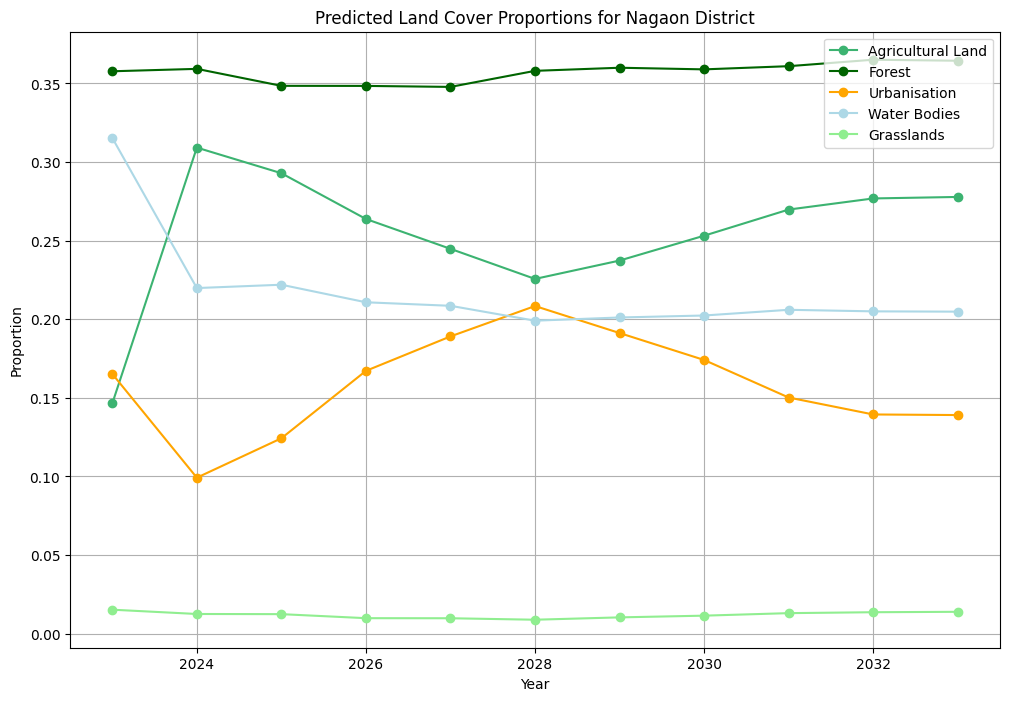

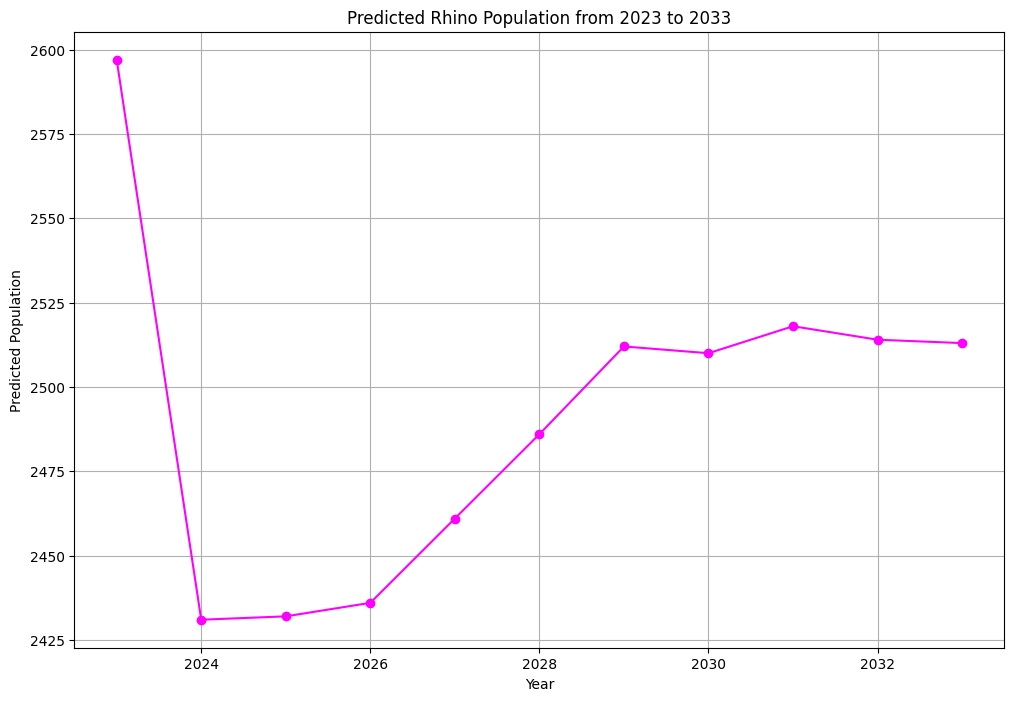

In [2]:
import numpy as np
import tensorflow as tf
import random
import os
import pandas as pd
import cv2
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import GRU, Dense
from math import ceil
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'


tf.get_logger().setLevel('ERROR')  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

lulc_paths = {
    'Golaghat': {
        '2012': '/kaggle/input/land-use-cover-g/2012.jpg',
        '2013': '/kaggle/input/land-use-cover-g/2013.jpg',
        '2015': '/kaggle/input/land-use-cover-g/2015.jpg',
        '2016': '/kaggle/input/land-use-cover-g/2016.jpg',
        '2018': '/kaggle/input/land-use-cover-g/2018.jpg',
        '2019': '/kaggle/input/land-use-cover-g/2019.png',
        '2021': '/kaggle/input/land-use-cover-g/2022.jpg',
        '2022': '/kaggle/input/land-use-cover-g/2022.jpg'
    },
    'Nagaon': {
        '2012': '/kaggle/input/land-use-cover-nagaon/2012.jpg',
        '2013': '/kaggle/input/land-use-cover-nagaon/2013.jpg',
        '2015': '/kaggle/input/land-use-cover-nagaon/2015.jpg',
        '2016': '/kaggle/input/land-use-cover-nagaon/2016.jpg',
        '2018': '/kaggle/input/land-use-cover-nagaon/2018.jpg',
        '2019': '/kaggle/input/land-use-cover-nagaon/2019.jpg',
        '2021': '/kaggle/input/land-use-cover-nagaon/2022.png',
        '2022': '/kaggle/input/land-use-cover-nagaon/2022.png'
    }
}

rhino_population = {
    '2012': 2290,
    '2013': 2329,
    '2015': 2401,
    '2016': 2401,
    '2018': 2413,
    '2019': 2413,
    '2021': 2613,
    '2022': 2613
}

def load_efficientnet_model():
    module_url = "https://tfhub.dev/google/efficientnet/b3/feature-vector/1"
    model = hub.KerasLayer(module_url, trainable=False)
    return model

def load_and_preprocess_image(path, target_size=(300, 300)):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

def extract_features_efficientnet(model, imgs):
    imgs = np.array(imgs)
    features = model(imgs)  
    return features.numpy() 

def calculate_land_cover_features(lulc_paths):
    features_data = []
    efficientnet_model = load_efficientnet_model()

    for district, year_paths in lulc_paths.items():
        for year, path in year_paths.items():
            try:
                img = load_and_preprocess_image(path)
                features = extract_features_efficientnet(efficientnet_model, [img])[0]  # Extract features for the image

                features_data.append({
                    'District': district,
                    'Year': int(year),
                    'Features': features
                })

            except Exception as e:
                print(f"Error processing {year} for {district}: {e}")

    return features_data

def prepare_data(features_data, rhino_population, district):
    district_data = [entry for entry in features_data if entry['District'] == district]
    
    district_data.sort(key=lambda x: x['Year'])
    
    years = [entry['Year'] for entry in district_data]
    features = [entry['Features'] for entry in district_data]
    
    features.append(features[-1])
    years.append(years[-1])
    
    lagged_features = np.roll(features, shift=1, axis=0)  # Lagged features (shifted by 1 year)
    lagged_average_features = (features + lagged_features) / 2  # Lagged average features
    moving_average_features = pd.DataFrame(features).rolling(window=3, min_periods=1).mean().values  # Moving average features
    

    all_features = np.concatenate([features, lagged_features, lagged_average_features, moving_average_features], axis=1)
    target_population = np.array([rhino_population[str(year)] for year in years])
    
    return all_features, target_population

def create_gru_sequences(features, n_lags=3):
    sequences = []
    targets = []
    for i in range(n_lags, len(features)):
        sequences.append(features[i - n_lags:i])
        targets.append(features[i])
    return np.array(sequences), np.array(targets)

def train_gru_model(sequences, targets):
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(sequences.shape[1], sequences.shape[2])))
    model.add(Dense(targets.shape[1]))
    model.compile(optimizer='adam', loss='mse')

    tf.get_logger().setLevel('ERROR') 
    
    model.fit(sequences, targets, epochs=200, verbose=0)  
    return model

def decode_land_cover(features, decoder_model):

    decoded_output = decoder_model.predict(features.reshape(1, -1))
    agricultural_land, forests, urbanisation, water_bodies, grasslands = decoded_output[0]
    total = agricultural_land + forests + urbanisation + water_bodies + grasslands
    return {
        'Agricultural Land': agricultural_land / total,
        'Forest': forests / total,
        'Urbanisation': urbanisation / total,
        'Water Bodies': water_bodies / total,
        'Grasslands': grasslands / total
    }

def generate_suggestions(land_cover):
    suggestions = []


    if land_cover['Grasslands'] < 0.3:
        suggestions.append("Increase grassland areas to provide more grazing habitats for rhinos.")
    if land_cover['Water Bodies'] < 0.1:
        suggestions.append("Ensure adequate water bodies to support rhino hydration and mud wallows.")
    if land_cover['Forest'] > 0.4:
        suggestions.append("Maintain forest cover for shelter while preventing overgrowth to ensure sufficient grasslands.")
    if land_cover['Agricultural Land'] > 0.2:
        suggestions.append("Limit agricultural expansion to preserve natural habitats.")
    if land_cover['Urbanisation'] > 0.1:
        suggestions.append("Control urban development to minimize habitat fragmentation and human-wildlife conflict.")
    
    return suggestions

def visualize_land_cover(data):
    categories = ['Agricultural Land', 'Forest', 'Urbanisation', 'Water Bodies', 'Grasslands']
    
    for district in ['Golaghat', 'Nagaon']:
        years = sorted(data.keys())
        land_cover = {category: [data[year][district][category] for year in years] for category in categories}

        plt.figure(figsize=(12, 8))

    
        custom_colors = ['mediumseagreen', 'darkgreen', 'orange', 'lightblue', 'lightgreen']
        
        for i, category in enumerate(categories):
            plt.plot(years, land_cover[category], label=category, marker='o', color=custom_colors[i])

        plt.xlabel('Year')
        plt.ylabel('Proportion')
        plt.title(f'Predicted Land Cover Proportions for {district} District')
        plt.legend()
        plt.grid(True)
        plt.show()

try:
    
    features_data = calculate_land_cover_features(lulc_paths)
    
    
    golaghat_features, golaghat_population = prepare_data(features_data, rhino_population, 'Golaghat')
    
    
    nagaon_features, nagaon_population = prepare_data(features_data, rhino_population, 'Nagaon')

    combined_features = np.concatenate([golaghat_features, nagaon_features])
    combined_population = np.concatenate([golaghat_population, nagaon_population])

    sequences, targets = create_gru_sequences(combined_features)
    
    gru_model = train_gru_model(sequences, targets)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(combined_features, combined_population)

    decoder_model = Sequential()
    decoder_model.add(Dense(50, activation='relu', input_dim=combined_features.shape[1]))
    decoder_model.add(Dense(5, activation='softmax'))
    decoder_model.compile(optimizer='adam', loss='mse')

    decoder_model.fit(combined_features, np.random.rand(len(combined_features), 5), epochs=100, verbose=0)  # Set verbose=0 to suppress progress bars

    predicted_population = {}
    land_cover_data = {}

    
    golaghat_pred_features = np.mean(golaghat_features[-1:], axis=0)
    nagaon_pred_features = np.mean(nagaon_features[-1:], axis=0)
    combined_pred_features = np.mean([golaghat_pred_features, nagaon_pred_features], axis=0)
    combined_pred_features_tensor = tf.convert_to_tensor(combined_pred_features, dtype=tf.float32)
    predicted_population[2023] = ceil(rf_model.predict(combined_pred_features_tensor.numpy().reshape(1, -1))[0])  # Round prediction

    land_cover_data[2023] = {
        'Golaghat': decode_land_cover(golaghat_pred_features, decoder_model),
        'Nagaon': decode_land_cover(nagaon_pred_features, decoder_model)
    }

   
    print(f"\033[1m \033[4mPredictions for 2023:\033[0m")
    print(f"  \033[1mPredicted Population: \033[1m \033[4m{predicted_population[2023]}\033[0m\n")
    print(f"  \033[1mGolaghat Land Cover: \033[0m{land_cover_data[2023]['Golaghat']}\n")
    print(f"  \033[1mNagaon Land Cover: \033[0m{land_cover_data[2023]['Nagaon']}\n")

    
    for district in ['Golaghat', 'Nagaon']:
        print(f"  \033[1mSuggestions for {district} in 2023:")
        suggestions = generate_suggestions(land_cover_data[2023][district])
        for suggestion in suggestions:
            print(f"  - \033[0m{suggestion}")
        print()

    
    for year in range(2024, 2034):
        
        golaghat_gru_input = np.array([golaghat_pred_features] * sequences.shape[1])
        nagaon_gru_input = np.array([nagaon_pred_features] * sequences.shape[1])

        golaghat_pred_features = gru_model.predict(golaghat_gru_input.reshape(1, sequences.shape[1], sequences.shape[2]))[0]
        nagaon_pred_features = gru_model.predict(nagaon_gru_input.reshape(1, sequences.shape[1], sequences.shape[2]))[0]

        
        combined_pred_features = np.mean([golaghat_pred_features, nagaon_pred_features], axis=0)
        predicted_population[year] = ceil(rf_model.predict(combined_pred_features.reshape(1, -1))[0])  # Round prediction

        
        current_land_cover_golaghat = decode_land_cover(golaghat_pred_features, decoder_model)
        current_land_cover_nagaon = decode_land_cover(nagaon_pred_features, decoder_model)

        
        land_cover_data[year] = {
            'Golaghat': current_land_cover_golaghat,
            'Nagaon': current_land_cover_nagaon
        }

        
        print(f"\033[1m \033[4mPredictions for {year}:\033[0m \n")
        print(f"  \033[1mPredicted Population: \033[1m \033[4m{predicted_population[year]}\033[0m\n")
        print(f"  \033[1mGolaghat Land Cover:\033[0m {current_land_cover_golaghat}\n")
        print(f"  \033[1mNagaon Land Cover:\033[0m {current_land_cover_nagaon}\n")


        
        for district in ['Golaghat', 'Nagaon']:
            print(f"  \033[1mSuggestions for {district} in {year}:")
            suggestions = generate_suggestions(land_cover_data[year][district])
            for suggestion in suggestions:
                print(f"  - \033[0m{suggestion}")
            print()

   
    visualize_land_cover(land_cover_data)

    
    plt.figure(figsize=(12, 8))
    plt.plot(predicted_population.keys(), predicted_population.values(), marker='o', linestyle='-', color='magenta')
    plt.xlabel('Year')
    plt.ylabel('Predicted Population')
    plt.title('Predicted Rhino Population from 2023 to 2033')
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error occurred: {e}")


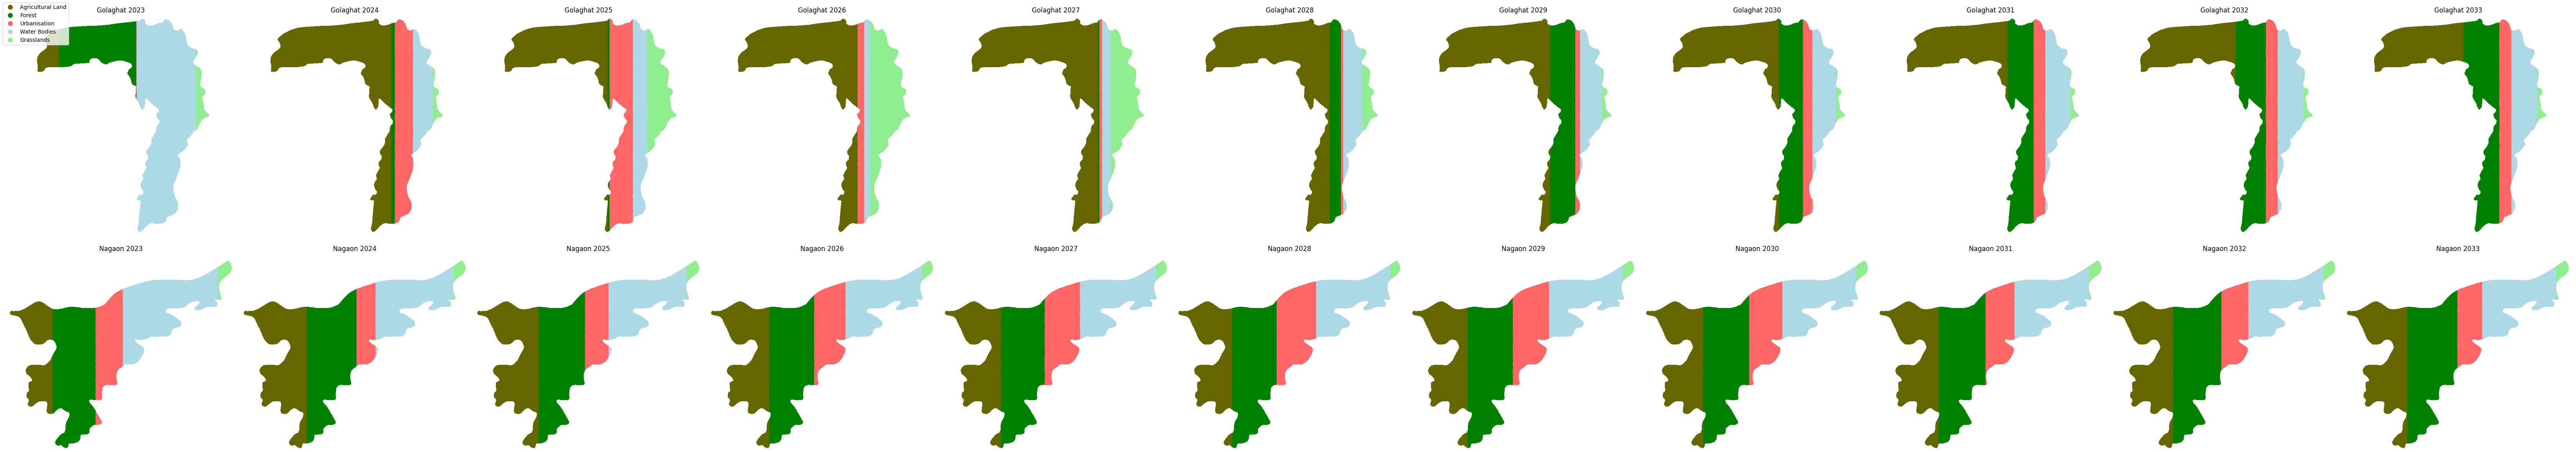

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_and_fill_land_cover(map_path, land_cover_data, year, district, ax):
    map_image = cv2.imread(map_path)
    
    map_image_rgb = cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)
    
    gray_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray_image, 240, 255, cv2.THRESH_BINARY_INV)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    largest_contour = max(contours, key=cv2.contourArea)
    
    contour_mask = np.zeros_like(gray_image)
    cv2.drawContours(contour_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
    filled_image = np.ones_like(map_image_rgb) * 255  
    
    land_cover_colors = {
        'Agricultural Land': (102, 102, 0),   
        'Forest': (0, 128, 0),                 
        'Urbanisation': (255, 102, 102),       
        'Water Bodies': (173, 216, 230),       
        'Grasslands': (144, 238, 144)          
    }
    
    proportions = np.array(list(land_cover_data.values()))
    proportions = proportions / proportions.sum()
    intervals = np.cumsum(proportions)
    
    coords = np.column_stack(np.where(contour_mask == 255))
    
    coords = coords[np.argsort(coords[:, 1])]
    
    start = 0
    for i, (category, proportion) in enumerate(land_cover_data.items()):
        color = land_cover_colors.get(category, (128, 128, 128))  
        
        end = int(len(coords) * intervals[i])
        for coord in coords[start:end]:
            filled_image[coord[0], coord[1]] = color
        start = end
    
    ax.imshow(filled_image.astype(np.uint8))
    ax.set_title(f'{district} {year}')
    ax.axis('off')

golaghat_map_path = '/kaggle/input/district/golaghat_map.png'
nagaon_map_path = '/kaggle/input/district/nagaon_map.jpg'


predicted_land_cover = {
    2023: {
        'Golaghat': {'Agricultural Land': 0.0482574, 'Forest': 0.23606929, 'Urbanisation': 0.0032306642, 'Water Bodies': 0.6784928, 'Grasslands': 0.033949833},
        'Nagaon': {'Agricultural Land': 0.14644773, 'Forest': 0.35770446, 'Urbanisation': 0.16524155, 'Water Bodies': 0.31532818, 'Grasslands': 0.015278125}
    },
    2024: {
        'Golaghat': {'Agricultural Land': 0.5239197, 'Forest': 0.054502945, 'Urbanisation': 0.25934482, 'Water Bodies': 0.14635848, 'Grasslands': 0.015874075},
        'Nagaon': {'Agricultural Land': 0.30916107, 'Forest': 0.35923904, 'Urbanisation': 0.099228576, 'Water Bodies': 0.21983236, 'Grasslands': 0.012538973}
    },
    2025: {
        'Golaghat': {'Agricultural Land': 0.3141114, 'Forest': 0.019913314, 'Urbanisation': 0.3106262, 'Water Bodies': 0.19767329, 'Grasslands': 0.15767582},
        'Nagaon': {'Agricultural Land': 0.29286864, 'Forest': 0.34844658, 'Urbanisation': 0.12429492, 'Water Bodies': 0.22194995, 'Grasslands': 0.012439919}
    },
    2026: {
        'Golaghat': {'Agricultural Land': 0.49794883, 'Forest': 0.008565481, 'Urbanisation': 0.104128234, 'Water Bodies': 0.09025415, 'Grasslands': 0.2991033},
        'Nagaon': {'Agricultural Land': 0.2637638, 'Forest': 0.34839448, 'Urbanisation': 0.16717534, 'Water Bodies': 0.21078813, 'Grasslands': 0.009878357}
    },
    2027: {
        'Golaghat': {'Agricultural Land': 0.60557, 'Forest': 0.02476525, 'Urbanisation': 0.042950906, 'Water Bodies': 0.12477699, 'Grasslands': 0.20193684},
        'Nagaon': {'Agricultural Land': 0.24477103, 'Forest': 0.3477665, 'Urbanisation': 0.18908677, 'Water Bodies': 0.20854641, 'Grasslands': 0.009829328}
    },
    2028: {
        'Golaghat': {'Agricultural Land': 0.5765448, 'Forest': 0.17140546, 'Urbanisation': 0.032416344, 'Water Bodies': 0.17335446, 'Grasslands': 0.04627891},
        'Nagaon': {'Agricultural Land': 0.22563799, 'Forest': 0.35798258, 'Urbanisation': 0.20840329, 'Water Bodies': 0.19908133, 'Grasslands': 0.008894846}
    },
    2029: {
        'Golaghat': {'Agricultural Land': 0.3961998, 'Forest': 0.3651066, 'Urbanisation': 0.060752314, 'Water Bodies': 0.16288425, 'Grasslands': 0.015056962},
        'Nagaon': {'Agricultural Land': 0.23732075, 'Forest': 0.35995468, 'Urbanisation': 0.19122203, 'Water Bodies': 0.20111665, 'Grasslands': 0.010385906}
    },
    2030: {
        'Golaghat': {'Agricultural Land': 0.34377143, 'Forest': 0.3243126, 'Urbanisation': 0.13655025, 'Water Bodies': 0.18337469, 'Grasslands': 0.011991037},
        'Nagaon': {'Agricultural Land': 0.2531311, 'Forest': 0.3589168, 'Urbanisation': 0.17409718, 'Water Bodies': 0.20237511, 'Grasslands': 0.011479853}
    },
    2031: {
        'Golaghat': {'Agricultural Land': 0.29640213, 'Forest': 0.3224482, 'Urbanisation': 0.17252469, 'Water Bodies': 0.19625613, 'Grasslands': 0.01236885},
        'Nagaon': {'Agricultural Land': 0.2697542, 'Forest': 0.36094818, 'Urbanisation': 0.15021296, 'Water Bodies': 0.20600478, 'Grasslands': 0.013079928}
    },
    2032: {
        'Golaghat': {'Agricultural Land': 0.26649317, 'Forest': 0.33231184, 'Urbanisation': 0.17947213, 'Water Bodies': 0.20870517, 'Grasslands': 0.01301768},
        'Nagaon': {'Agricultural Land': 0.2768266, 'Forest': 0.3650534, 'Urbanisation': 0.13943942, 'Water Bodies': 0.2063745, 'Grasslands': 0.0123061}
    },
    2033: {
        'Golaghat': {'Agricultural Land': 0.2430734, 'Forest': 0.34941718, 'Urbanisation': 0.18344867, 'Water Bodies': 0.21146719, 'Grasslands': 0.012593371},
        'Nagaon': {'Agricultural Land': 0.2835625, 'Forest': 0.3720452, 'Urbanisation': 0.12663524, 'Water Bodies': 0.20492333, 'Grasslands': 0.012833684}
    }
}


years = list(predicted_land_cover.keys())
num_years = len(years)

fig, axs = plt.subplots(2, num_years, figsize=(num_years * 6, 12))

for i, year in enumerate(years):
    extract_and_fill_land_cover(golaghat_map_path, predicted_land_cover[year]['Golaghat'], year, 'Golaghat', axs[0, i])
    extract_and_fill_land_cover(nagaon_map_path, predicted_land_cover[year]['Nagaon'], year, 'Nagaon', axs[1, i])

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(102/255, 102/255, 0), markersize=10, label='Agricultural Land'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(0/255, 128/255, 0), markersize=10, label='Forest'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(255/255, 102/255, 102/255), markersize=10, label='Urbanisation'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(173/255, 216/255, 230/255), markersize=10, label='Water Bodies'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(144/255, 238/255, 144/255), markersize=10, label='Grasslands')
]

fig.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()
for i, year in enumerate(years):
    fig.savefig(f'predicted_land_cover_{year}.png')


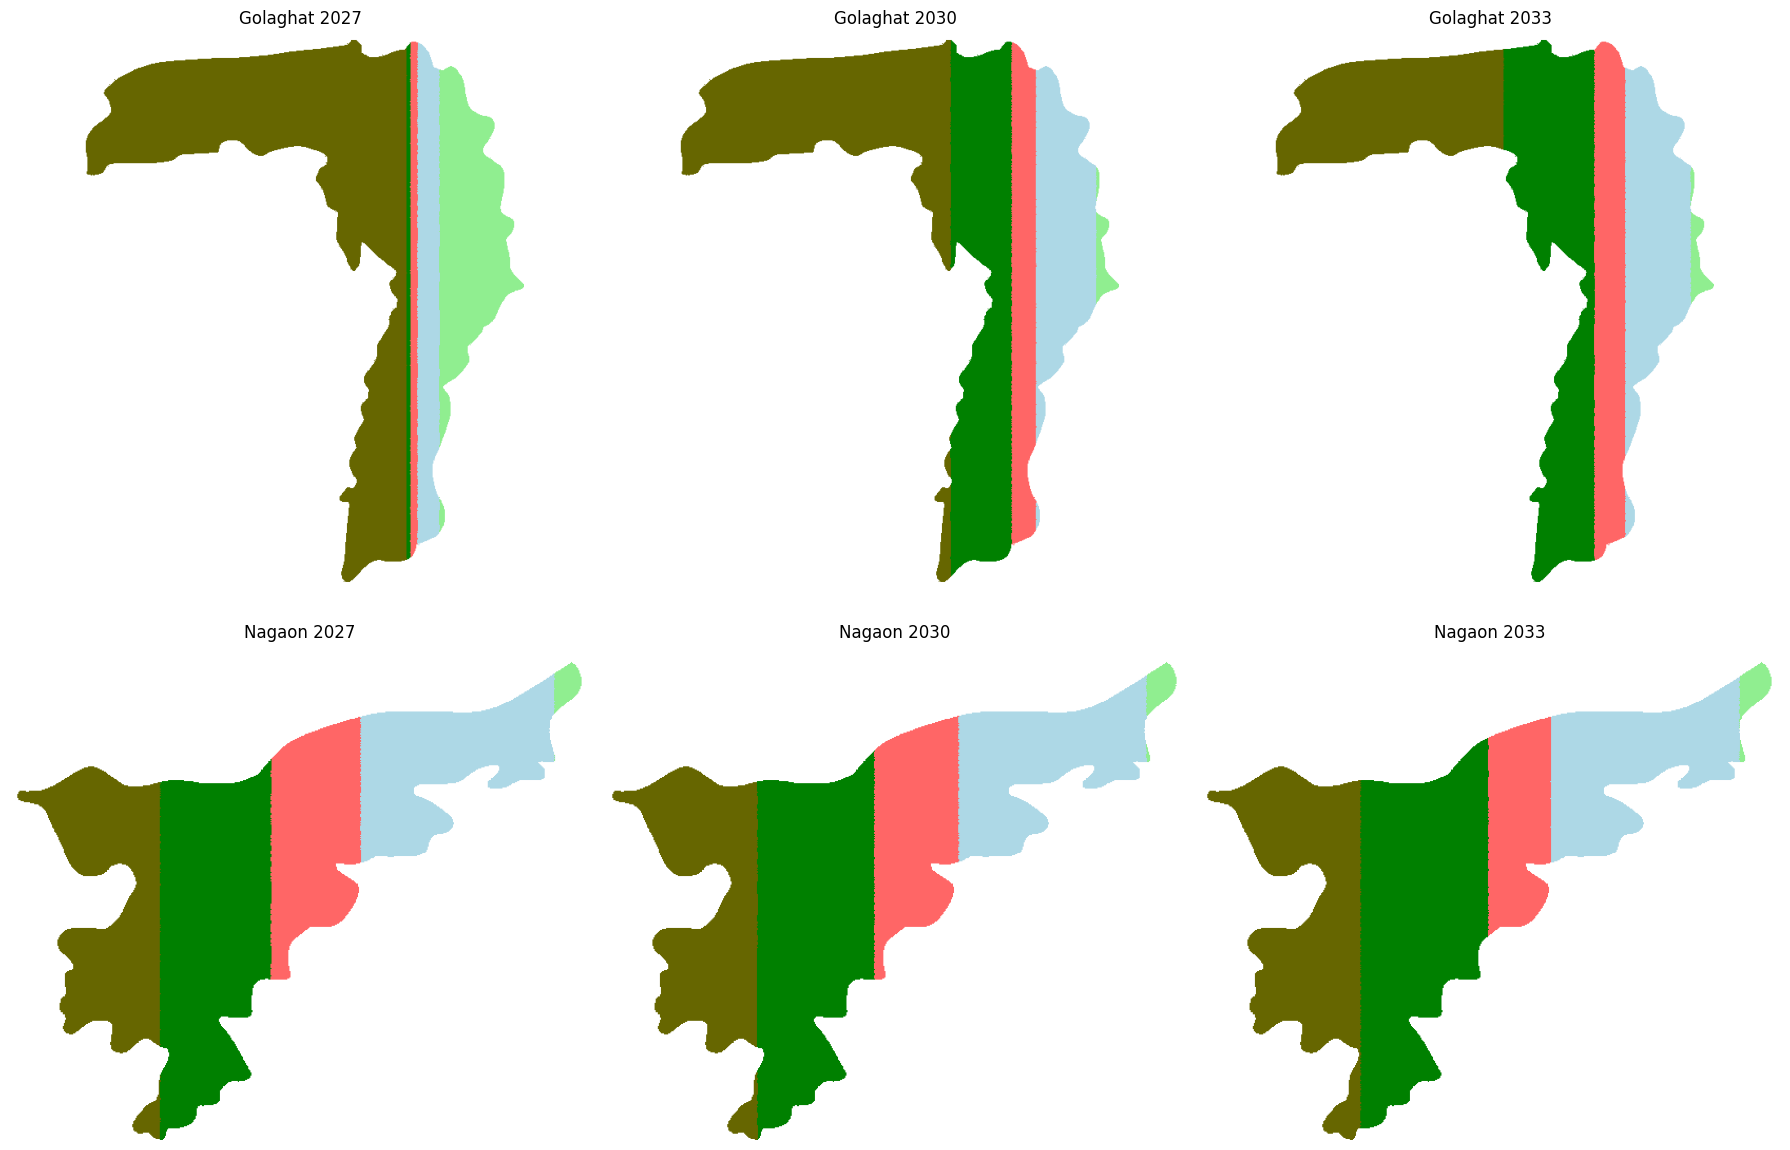

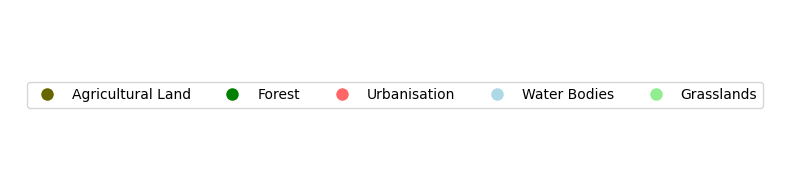

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def extract_and_fill_land_cover(map_path, land_cover_data, year, district, ax):
    map_image = cv2.imread(map_path)
    
    map_image_rgb = cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)
    
    gray_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray_image, 240, 255, cv2.THRESH_BINARY_INV)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    largest_contour = max(contours, key=cv2.contourArea)
    
    contour_mask = np.zeros_like(gray_image)
    cv2.drawContours(contour_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
    filled_image = np.ones_like(map_image_rgb) * 255  
    
    land_cover_colors = {
        'Agricultural Land': (102, 102, 0),    # Brownish Green
        'Forest': (0, 128, 0),                 # Green
        'Urbanisation': (255, 102, 102),       # Light Red
        'Water Bodies': (173, 216, 230),       # Light Blue
        'Grasslands': (144, 238, 144)          # Light Green
    }
    
    proportions = np.array(list(land_cover_data.values()))
    proportions = proportions / proportions.sum()
    intervals = np.cumsum(proportions)
    
    coords = np.column_stack(np.where(contour_mask == 255))
    
    coords = coords[np.argsort(coords[:, 1])]
    
    start = 0
    for i, (category, proportion) in enumerate(land_cover_data.items()):
        color = land_cover_colors.get(category, (128, 128, 128))  # Default to gray if color not defined
        
        end = int(len(coords) * intervals[i])
        for coord in coords[start:end]:
            filled_image[coord[0], coord[1]] = color
        start = end
    
    ax.imshow(filled_image.astype(np.uint8))
    ax.set_title(f'{district} {year}')
    ax.axis('off')

golaghat_map_path = '/kaggle/input/district/golaghat_map.png'
nagaon_map_path = '/kaggle/input/district/nagaon_map.jpg'

predicted_land_cover = {
    2027: {
        'Golaghat': {'Agricultural Land': 0.60557, 'Forest': 0.02476525, 'Urbanisation': 0.042950906, 'Water Bodies': 0.12477699, 'Grasslands': 0.20193684},
        'Nagaon': {'Agricultural Land': 0.24477103, 'Forest': 0.3477665, 'Urbanisation': 0.18908677, 'Water Bodies': 0.20854641, 'Grasslands': 0.009829328}
    },
    2030: {
        'Golaghat': {'Agricultural Land': 0.34377143, 'Forest': 0.3243126, 'Urbanisation': 0.13655025, 'Water Bodies': 0.18337469, 'Grasslands': 0.011991037},
        'Nagaon': {'Agricultural Land': 0.2531311, 'Forest': 0.3589168, 'Urbanisation': 0.17409718, 'Water Bodies': 0.20237511, 'Grasslands': 0.011479853}
    },
    2033: {
        'Golaghat': {'Agricultural Land': 0.2430734, 'Forest': 0.34941718, 'Urbanisation': 0.18344867, 'Water Bodies': 0.21146719, 'Grasslands': 0.012593371},
        'Nagaon': {'Agricultural Land': 0.2835625, 'Forest': 0.3720452, 'Urbanisation': 0.12663524, 'Water Bodies': 0.20492333, 'Grasslands': 0.012833684}
    }
}

years = list(predicted_land_cover.keys())
num_years = len(years)

fig, axs = plt.subplots(2, num_years, figsize=(num_years * 6, 12))

for i, year in enumerate(years):
    extract_and_fill_land_cover(golaghat_map_path, predicted_land_cover[year]['Golaghat'], year, 'Golaghat', axs[0, i])
    extract_and_fill_land_cover(nagaon_map_path, predicted_land_cover[year]['Nagaon'], year, 'Nagaon', axs[1, i])

plt.tight_layout()
plt.show()

fig_legend, ax_legend = plt.subplots(figsize=(8, 2))

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(102/255, 102/255, 0), markersize=10, label='Agricultural Land'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(0/255, 128/255, 0), markersize=10, label='Forest'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(255/255, 102/255, 102/255), markersize=10, label='Urbanisation'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(173/255, 216/255, 230/255), markersize=10, label='Water Bodies'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=(144/255, 238/255, 144/255), markersize=10, label='Grasslands')
]

fig_legend.legend(handles=legend_elements, loc='center', ncol=5)
ax_legend.axis('off')

plt.tight_layout()
plt.show()
fig_legend.savefig('legend.png')


In [12]:
import numpy as np
import pandas as pd
import cv2
import os

# Define paths to land use/land cover images
lulc_paths = {
    'Golaghat': {
        '2023': '/kaggle/input/land-use-cover-g/2023.jpg'
    },
    'Nagaon': {
        '2023': '/kaggle/input/land-use-cover-nagaon/2023.jpg'
    }
}

# Rhino population data by year
rhino_population = {
    '2023': 2552
}

# Function to read and preprocess images
def read_and_preprocess_image(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not loaded correctly: {path}")
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    return img

# Function to calculate land cover percentages
def calculate_land_cover_percentages(lulc_paths):
    land_cover_data = {}
    for district, year_paths in lulc_paths.items():
        land_cover_data[district] = {}
        for year, path in year_paths.items():
            try:
                img = read_and_preprocess_image(path)
                total_pixels = img.shape[0] * img.shape[1]
                agricultural_pixels = np.count_nonzero(img == 128) / total_pixels
                forest_pixels = np.count_nonzero(img == 0) / total_pixels
                waterbody_pixels = np.count_nonzero(img == 64) / total_pixels  
                grassland_pixels = np.count_nonzero(img == 192) / total_pixels  
                urbanisation_pixels = np.count_nonzero(img == 255) / total_pixels

                land_cover_data[district][year] = {
                    'Total Pixels': total_pixels,
                    'Agricultural Land': agricultural_pixels,
                    'Forest': forest_pixels,
                    'Waterbodies': waterbody_pixels,
                    'Grasslands': grassland_pixels,
                    'Urbanisation': urbanisation_pixels,
                    'rhino_population': rhino_population.get(year, np.nan)  # Include rhino population for the specific year
                }
            except Exception as e:
                print(f"Error processing {year} for {district}: {e}")
    return land_cover_data

try:
    # Calculate land cover percentages
    land_cover_percentages = calculate_land_cover_percentages(lulc_paths)

    # Print the extracted features
    for district, years in land_cover_percentages.items():
        for year, cover_data in years.items():
            print(f"District: {district}, Year: {year}")
            print(f"Agricultural Land: {cover_data['Agricultural Land']:.4f}")
            print(f"Forest: {cover_data['Forest']:.4f}")
            print(f"Waterbodies: {cover_data['Waterbodies']:.4f}")
            print(f"Grasslands: {cover_data['Grasslands']:.4f}")
            print(f"Urbanisation: {cover_data['Urbanisation']:.4f}")
            print()

except Exception as e:
    print(f"Error during analysis: {e}")

District: Golaghat, Year: 2023
Agricultural Land: 0.0020
Forest: 0.0012
Waterbodies: 0.0124
Grasslands: 0.0001
Urbanisation: 0.0000

District: Nagaon, Year: 2023
Agricultural Land: 0.0045
Forest: 0.0001
Waterbodies: 0.0095
Grasslands: 0.0003
Urbanisation: 0.0000



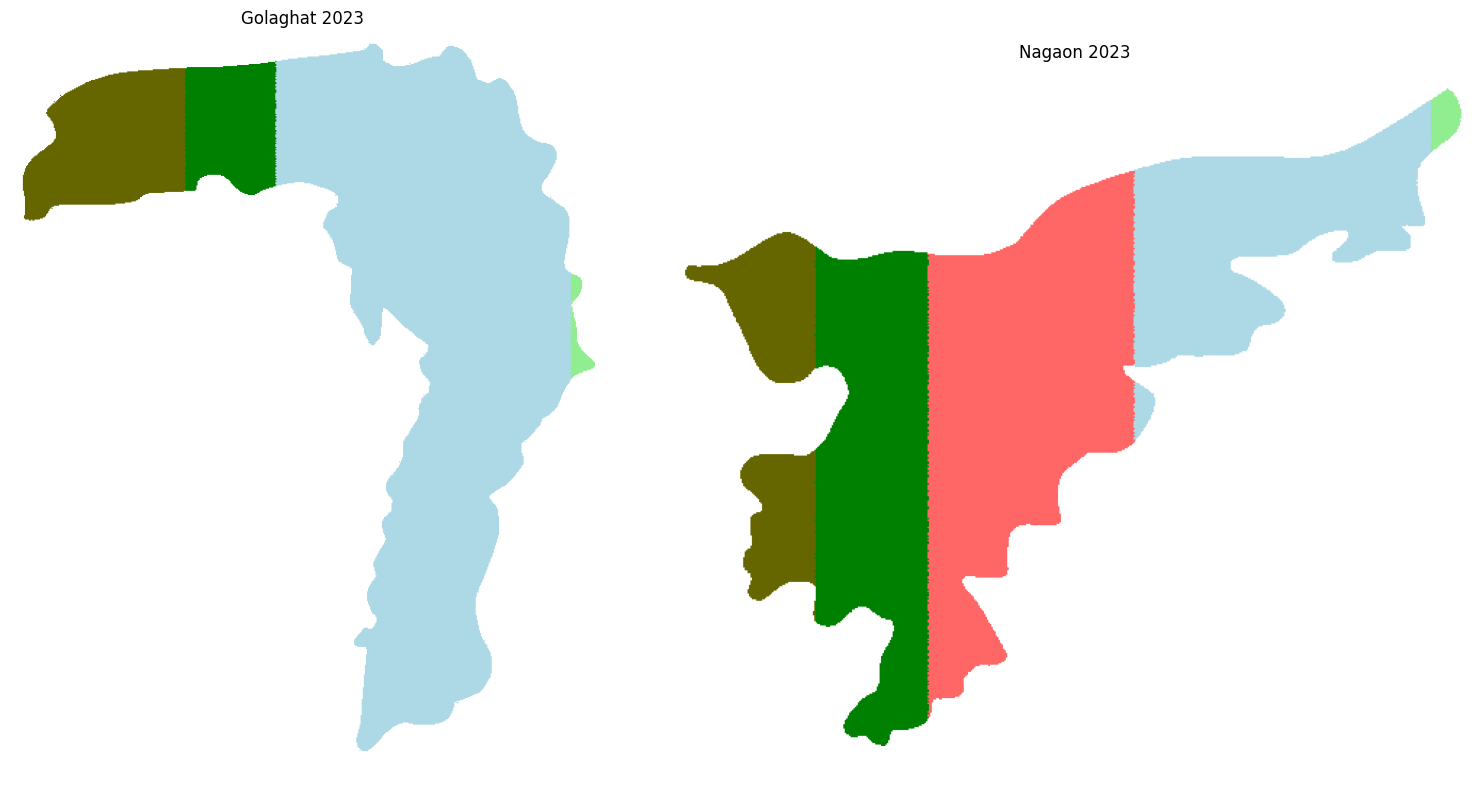

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_and_fill_land_cover(map_path, land_cover_data, year, district, ax):

    map_image = cv2.imread(map_path)
    
    map_image_rgb = cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)
    
    gray_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray_image, 240, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    largest_contour = max(contours, key=cv2.contourArea)
    
    contour_mask = np.zeros_like(gray_image)
    cv2.drawContours(contour_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
    filled_image = np.ones_like(map_image_rgb) * 255  
    
    land_cover_colors = {
        'Agricultural Land': (102, 102, 0),    
        'Forest': (0, 128, 0),                 
        'Urbanisation': (255, 102, 102),      
        'Water Bodies': (173, 216, 230),       
        'Grasslands': (144, 238, 144)          
    }
    
    proportions = np.array(list(land_cover_data.values()))
    proportions = proportions / proportions.sum()
    intervals = np.cumsum(proportions)
    
    coords = np.column_stack(np.where(contour_mask == 255))
    
    coords = coords[np.argsort(coords[:, 1])]
    start = 0
    for i, (category, proportion) in enumerate(land_cover_data.items()):
        color = land_cover_colors.get(category, (128, 128, 128))  # Default to gray if color not defined
        
        end = int(len(coords) * intervals[i])
        for coord in coords[start:end]:
            filled_image[coord[0], coord[1]] = color
        start = end
   
    ax.imshow(filled_image.astype(np.uint8))
    ax.set_title(f'{district} {year}')
    ax.axis('off')

    plt.savefig(f"{district}_{year}_ACTUAL.png", bbox_inches='tight')  # Save with tight bounding box

golaghat_map_path = '/kaggle/input/district/golaghat_map.png'
nagaon_map_path = '/kaggle/input/district/nagaon_map.jpg'

actual_land_cover_2023_golaghat = {
    'Agricultural Land': 0.0020,
    'Forest': 0.0012,
    'Urbanisation': 0.0000,
    'Water Bodies': 0.0124,
    'Grasslands': 0.0001
}

actual_land_cover_2023_nagaon = {
    'Agricultural Land': 0.0045,
    'Forest': 0.01,
    'Urbanisation': 0.015,
    'Water Bodies': 0.0095,
    'Grasslands': 0.0003
}

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
extract_and_fill_land_cover(golaghat_map_path, actual_land_cover_2023_golaghat, 2023, 'Golaghat', axs[0])
extract_and_fill_land_cover(nagaon_map_path, actual_land_cover_2023_nagaon, 2023, 'Nagaon', axs[1])
plt.tight_layout()
plt.show()


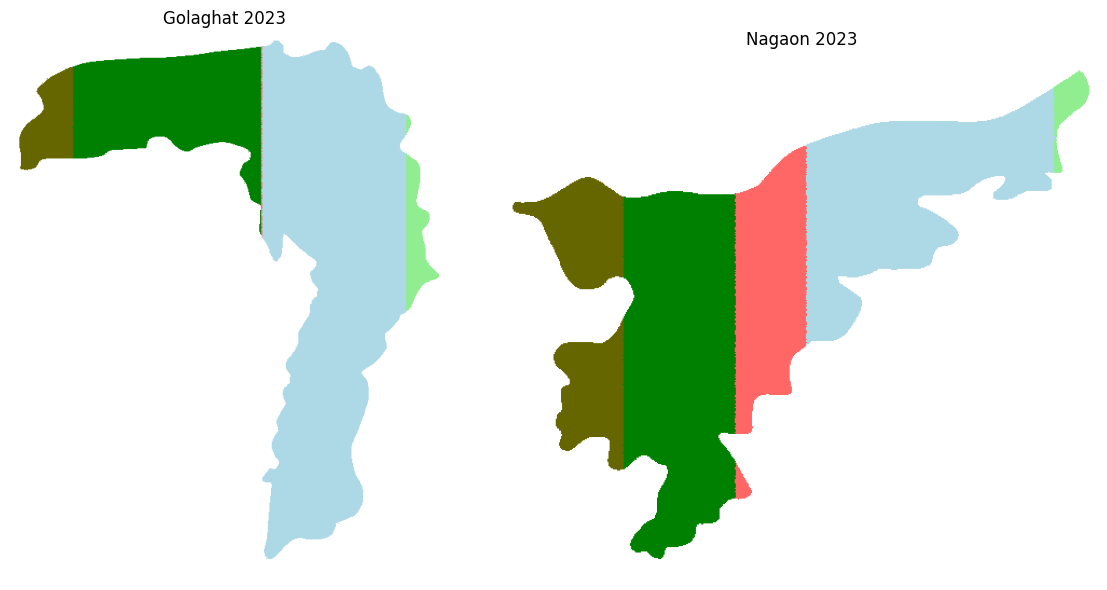

<Figure size 640x480 with 0 Axes>

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_and_fill_land_cover(map_path, land_cover_data, year, district, ax):
    map_image = cv2.imread(map_path)
    
    map_image_rgb = cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)
    
    gray_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray_image, 240, 255, cv2.THRESH_BINARY_INV)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    largest_contour = max(contours, key=cv2.contourArea)
    
    contour_mask = np.zeros_like(gray_image)
    cv2.drawContours(contour_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
    filled_image = np.ones_like(map_image_rgb) * 255  
    
    land_cover_colors = {
        'Agricultural Land': (102, 102, 0),    
        'Forest': (0, 128, 0),                 
        'Urbanisation': (255, 102, 102),       
        'Water Bodies': (173, 216, 230),       
        'Grasslands': (144, 238, 144)          
    }
    
    proportions = np.array(list(land_cover_data.values()))
    proportions = proportions / proportions.sum()
    intervals = np.cumsum(proportions)
    
    coords = np.column_stack(np.where(contour_mask == 255))
    
    coords = coords[np.argsort(coords[:, 1])]
    
    
    start = 0
    for i, (category, proportion) in enumerate(land_cover_data.items()):
        color = land_cover_colors.get(category, (128, 128, 128)) 
        
        end = int(len(coords) * intervals[i])
        for coord in coords[start:end]:
            filled_image[coord[0], coord[1]] = color
        start = end
    
    ax.imshow(filled_image.astype(np.uint8))
    ax.set_title(f'{district} {year}')
    ax.axis('off')

golaghat_map_path = '/kaggle/input/district/golaghat_map.png'
nagaon_map_path = '/kaggle/input/district/nagaon_map.jpg'

predicted_land_cover_2023_golaghat = {
    'Agricultural Land': 0.0482574, 'Forest': 0.23606929, 'Urbanisation': 0.0032306642, 'Water Bodies': 0.6784928, 'Grasslands': 0.033949833
}

predicted_land_cover_2023_nagaon = {
    'Agricultural Land': 0.14644773, 'Forest': 0.35770446, 'Urbanisation': 0.16524155, 'Water Bodies': 0.31532818, 'Grasslands': 0.015278125
}

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Extract and fill predicted land cover for Golaghat and Nagaon in 2023
extract_and_fill_land_cover(golaghat_map_path, predicted_land_cover_2023_golaghat, 2023, 'Golaghat', axs[0])
extract_and_fill_land_cover(nagaon_map_path, predicted_land_cover_2023_nagaon, 2023, 'Nagaon', axs[1])
plt.tight_layout()
plt.show()
plt.savefig('predicted_2023.png')
